## **SALES FORECASTING MODEL**

The objective of this model is to forecast the sales of individual products across the country. 

| ***The Data Dictionary*** |  |
| --------------------------- |----|
| **Column Name** | **Description** |
| *Target* | the total sales for a product category at a particular store at a given date |
| *Stores_id* | the unique store id |
| *Category_id* | the unique Product category id |
| *Date* | date in numerical representation |
| *Onpromotion* | gives the total number of items in a Product category that were being promoted at a store at a given date |
| *Nbr_of_transactions* | the total number of transactions happened at a store at a given date |
| *year_weekofyear* | the combination of the year and the week of the year, (year_weekofyear = year*100+week_of_year) |
| *ID* | the unique identifier for each row in the testing set: year_week_{year_weekofyear}_{store_id}_{Category_id} |


In [1]:
# Importation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read the data
df = pd.read_csv('../Data/train.csv')
df.dtypes

date                    object
store_id                object
category_id             object
target                 float64
onpromotion              int64
nbr_of_transactions      int64
dtype: object

In [3]:
#change date column to datetime
df['date'] = pd.to_datetime(df['date'])
df

,date,store_id,category_id,target,onpromotion,nbr_of_transactions
0,1900-12-30,store_1,category_24,0.00000,0,0
1,1900-12-30,store_1,category_21,0.00000,0,0
2,1900-12-30,store_1,category_32,0.00000,0,0
3,1900-12-30,store_1,category_18,0.00000,0,0
4,1900-12-30,store_1,category_26,0.00000,0,0
...,...,...,...,...,...,...
1048570,1902-08-10,store_3,category_23,929.36597,0,2953
1048571,1902-08-10,store_3,category_20,274.99300,0,2953
1048572,1902-08-10,store_3,category_15,6492.75600,0,2953
1048573,1902-08-10,store_3,category_29,1.00000,0,2953


In [4]:
start_date = df.date.min()
end_date = df.date.max()
date_range = pd.date_range(start=start_date, end= end_date, freq='D')
date_range
missing_date = date_range.difference(df.date)
missing_date

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

There is no missing data in this dataset

considering target is our sales per product, we can aggregate on date and product to have higher volume to forecast.

In [5]:
df['date'].max() - df['date'].min()

Timedelta('588 days 00:00:00')

In [6]:
agg_data = df.groupby(['date','category_id']).sum().reset_index().set_index('date')
agg_data

,category_id,store_id,target,onpromotion,nbr_of_transactions
date,,,,,
1900-12-30,category_0,store_1store_10store_11store_12store_13store_1...,33.000,0,1327
1900-12-30,category_1,store_1store_10store_11store_12store_13store_1...,2.000,0,1327
1900-12-30,category_10,store_1store_10store_11store_12store_13store_1...,3.000,0,1327
1900-12-30,category_11,store_1store_10store_11store_12store_13store_1...,2.000,0,1327
1900-12-30,category_12,store_1store_10store_11store_12store_13store_1...,160.157,0,1327
...,...,...,...,...,...
1902-08-10,category_5,store_1store_10store_11store_12store_13store_1...,4.000,0,29069
1902-08-10,category_6,store_1store_10store_11store_12store_13store_1...,18.000,0,29069
1902-08-10,category_7,store_1store_10store_11store_12store_13store_1...,58812.754,109,29069


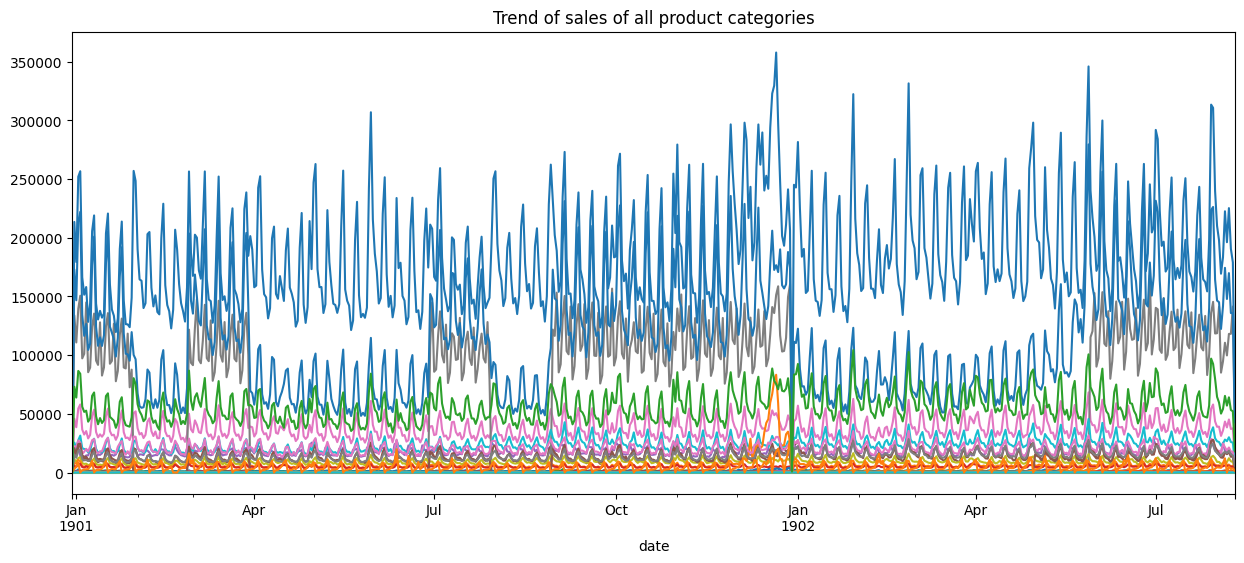

In [7]:
#check trend of all product categories 
for item in agg_data['category_id'].unique():
    data = agg_data[agg_data['category_id'] == item]['target']
    data.plot(figsize=(15,6))
plt.title('Trend of sales of all product categories')
plt.show()

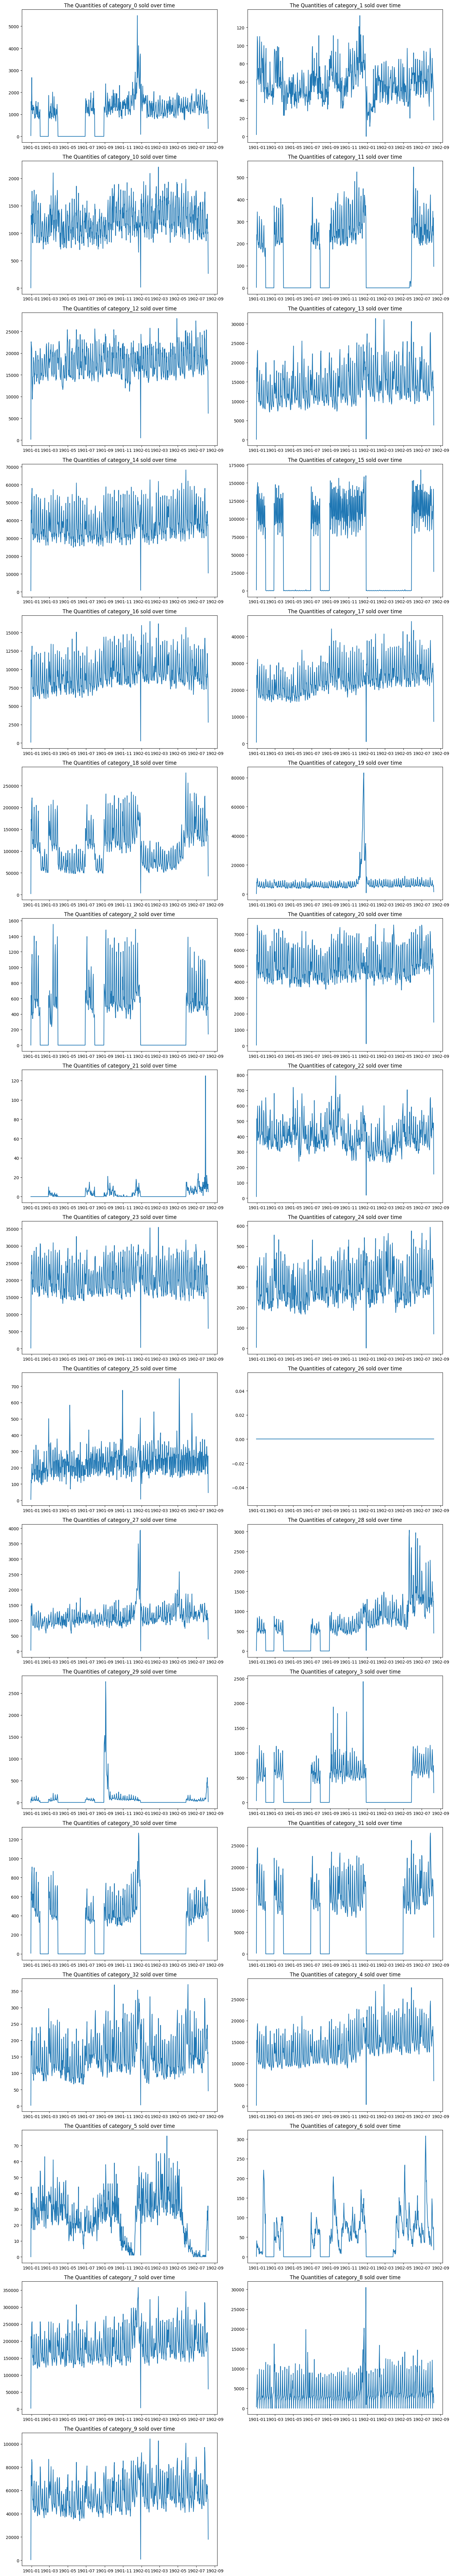

In [8]:
# Number of unique categories
unique_categories = agg_data['category_id'].unique()
num_categories = len(unique_categories)

# Determine the number of rows needed for the subplots
ncols = 2
nrows = (num_categories + ncols - 1) // ncols  # Ceiling division

# Create the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each category in its own subplot
for i, item in enumerate(unique_categories):
    data = agg_data[agg_data['category_id'] == item]['target']
    axs[i].plot(data)
    axs[i].set_title(f'The Quantities of {item} sold over time')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

All product categories have unique trendlines and would need to be forecasted individually to ensure accuracy in the forecast. 
We will first try out category 9.

In [9]:
#TOTAL SALES BY STORE
df.set_index('date')[['store_id','target']].groupby('store_id').sum()['target'].sort_values(ascending=False)

store_id
store_44    2.051180e+07
store_45    1.774406e+07
store_47    1.655630e+07
store_3     1.630356e+07
store_46    1.397884e+07
store_49    1.330216e+07
store_48    1.209627e+07
store_51    1.097985e+07
store_8     9.878487e+06
store_11    9.428144e+06
store_50    9.406428e+06
store_9     8.635926e+06
store_7     8.518235e+06
store_6     8.249544e+06
store_37    7.208776e+06
store_2     7.017366e+06
store_24    6.921107e+06
store_38    6.749113e+06
store_39    6.280036e+06
store_4     6.254607e+06
store_27    6.116281e+06
store_40    6.025417e+06
store_34    6.003480e+06
store_28    5.845018e+06
store_31    5.819290e+06
store_5     5.657240e+06
store_17    5.354225e+06
store_43    5.350787e+06
store_36    5.124252e+06
store_33    4.965377e+06
store_41    4.742559e+06
store_18    4.622883e+06
store_1     4.580670e+06
store_19    4.389362e+06
store_16    4.296874e+06
store_25    3.889975e+06
store_15    3.771490e+06
store_13    3.757670e+06
store_23    3.745887e+06
store_14    3.65

In [10]:
#AVERAGE SALES FOR EACH STORE
df.set_index('date')[['store_id','target']].groupby('store_id').mean()['target'].sort_values(ascending=False)

store_id
store_44    1057.091255
store_45     914.453740
store_47     853.241409
store_3      838.790158
store_46     720.410242
store_49     685.537046
store_48     623.390318
store_51     565.854998
store_8      509.095404
store_11     485.061693
store_50     484.767452
store_9      445.059038
store_7      438.993768
store_6      425.146544
store_37     371.509783
store_2      361.031332
store_24     356.078950
store_38     347.820700
store_39     323.646480
store_4      322.335939
store_27     314.672061
store_40     310.524465
store_34     309.393924
store_28     300.716062
store_31     299.901565
store_5      291.550197
store_43     275.756897
store_17     275.465585
store_36     264.082276
store_33     255.894486
store_41     244.411396
store_18     237.839326
store_1      235.667545
store_19     225.825092
store_16     221.066725
store_25     200.132462
store_15     194.036614
store_13     193.325593
store_23     192.719410
store_14     188.065350
store_54     177.561107
store_1

In [11]:
agg_data[agg_data['category_id'] == 'category_9'].drop(columns='category_id')

,store_id,target,onpromotion,nbr_of_transactions
date,,,,
1900-12-30,store_1store_10store_11store_12store_13store_1...,456.0,0,1327
1900-12-31,store_1store_10store_11store_12store_13store_1...,73045.0,0,90716
1901-01-01,store_1store_10store_11store_12store_13store_1...,63840.0,0,84488
1901-01-02,store_1store_10store_11store_12store_13store_1...,86517.0,0,101361
1901-01-03,store_1store_10store_11store_12store_13store_1...,84114.0,0,93475
...,...,...,...,...
1902-08-06,store_1store_10store_11store_12store_13store_1...,56966.0,85,79233
1902-08-07,store_1store_10store_11store_12store_13store_1...,64049.0,73,87127
1902-08-08,store_1store_10store_11store_12store_13store_1...,53217.0,77,82118


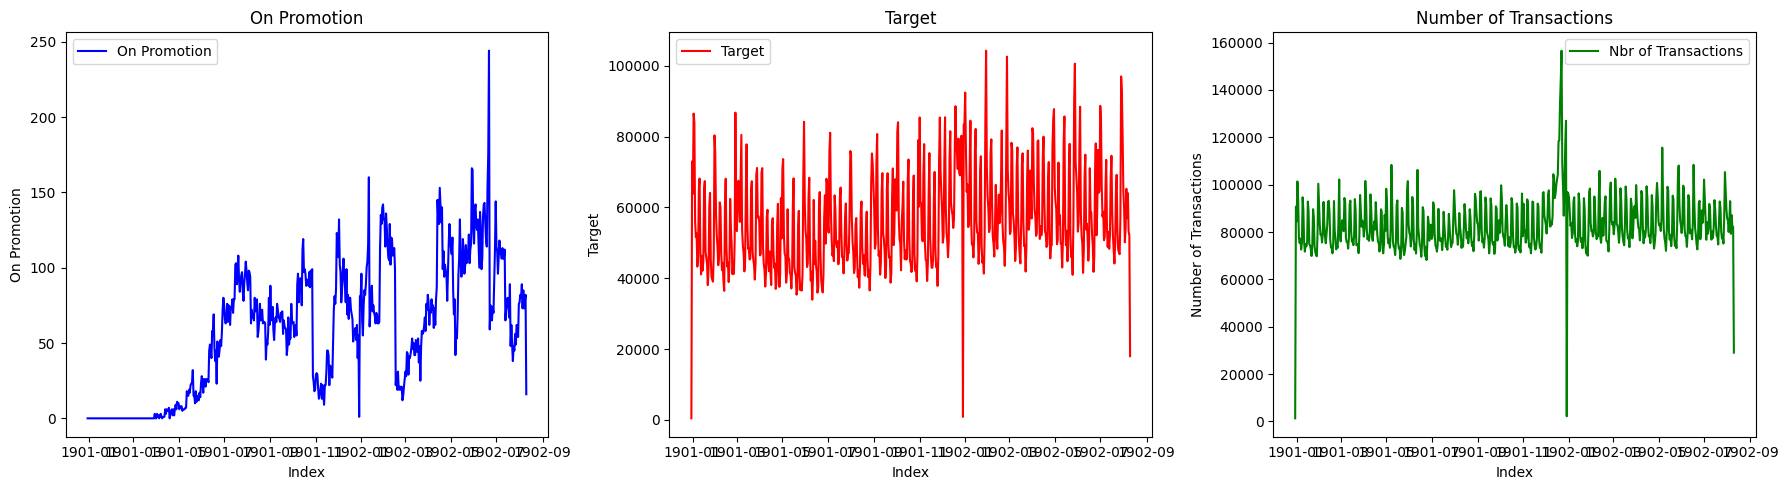

In [12]:
# Filter data for category_9
category_9_data = agg_data[agg_data['category_id'] == 'category_9'].drop(columns='category_id')

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot 'onpromotion'
axs[0].plot(category_9_data.index, category_9_data['onpromotion'], label='On Promotion', color='b')
axs[0].set_title('On Promotion')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('On Promotion')
axs[0].legend()

# Plot 'target'
axs[1].plot(category_9_data.index, category_9_data['target'], label='Target', color='r')
axs[1].set_title('Target')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Target')
axs[1].legend()

# Plot 'nbr_of_transactions'
axs[2].plot(category_9_data.index, category_9_data['nbr_of_transactions'], label='Nbr of Transactions', color='g')
axs[2].set_title('Number of Transactions')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Number of Transactions')
axs[2].legend()

plt.tight_layout()
plt.show()

* The trend of category_9 sales (target) seems to be in a fairly stable range across the entire period.
* The number of items on promotion show growth but in an irregular pattern

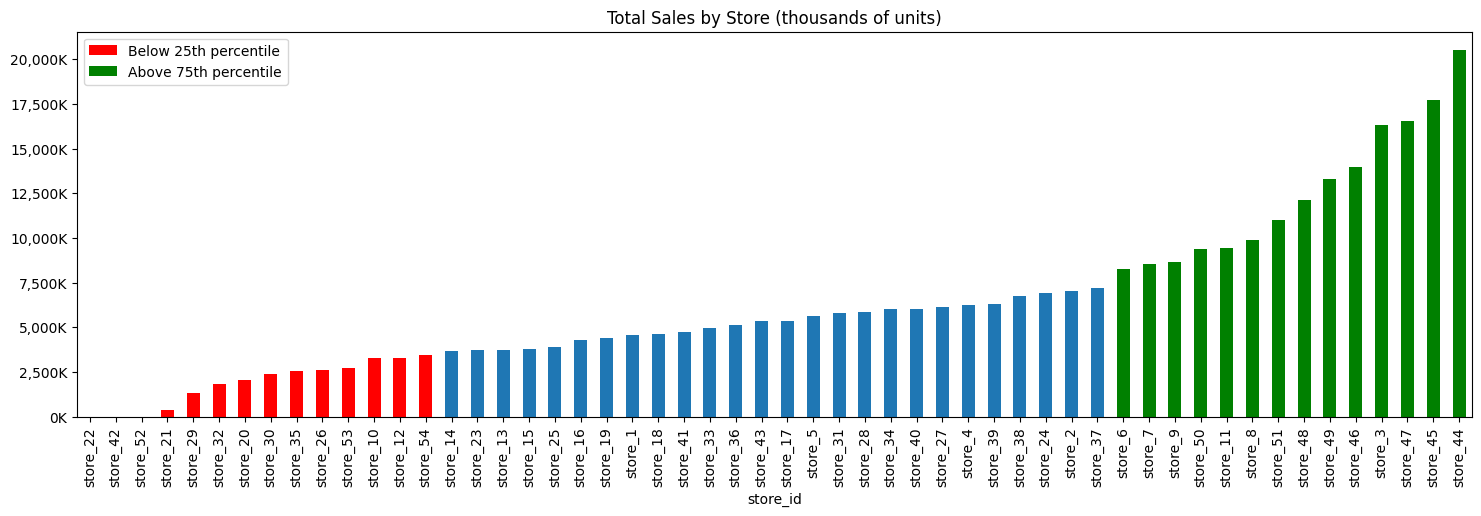

In [15]:
# Chec# Checking total store sales over the period
df_sales = df[['store_id','target']].groupby('store_id').sum().sort_values(by='target')

# Calculate percentile data
percentiles = df_sales['target'].quantile([0.25, 0.5, 0.75])

# Plot sales data
ax = df_sales.plot(kind='bar', figsize=(18,5), title='Total Sales by Store (thousands of units)')

# Set bar colors
for i, bar in enumerate(ax.patches):
    if df_sales.iloc[i]['target'] < percentiles[0.25]:
        bar.set_facecolor('red')
    elif df_sales.iloc[i]['target'] > percentiles[0.75]:
        bar.set_facecolor('green')

# Create proxy artists for legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='red', label='Below 25th percentile'),
    Patch(facecolor='green', label='Above 75th percentile')
]

# Add legend
import matplotlib.pyplot as plt
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'K'))
ax.legend(handles=legend_elements, loc='upper left')
plt.show()

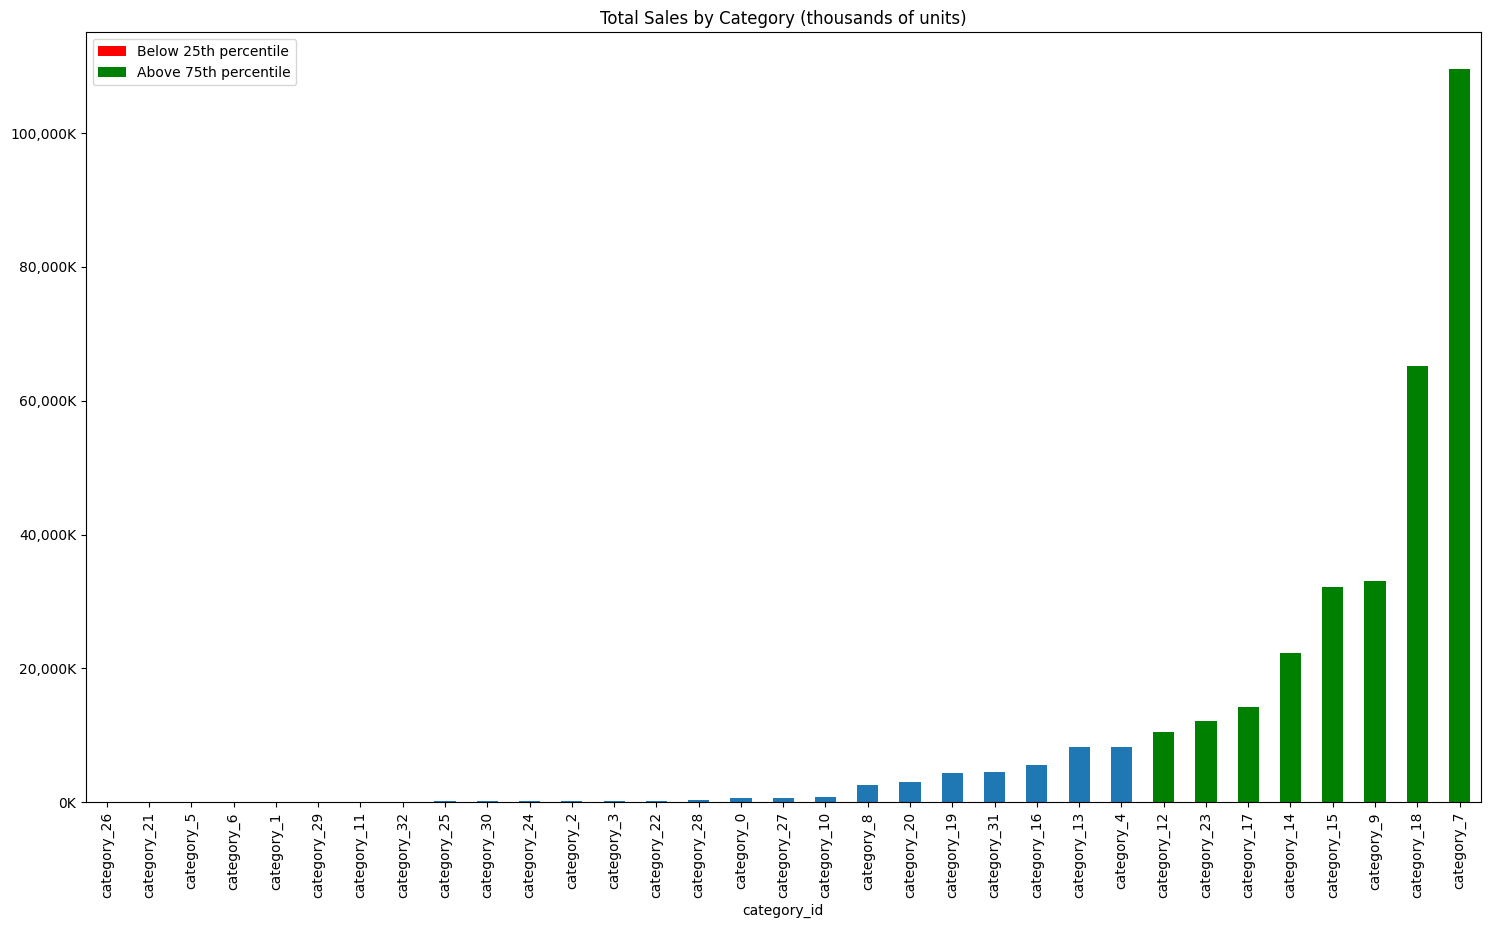

In [17]:
# Check Checking total store sales over the period
df_sales = df[['category_id','target']].groupby('category_id').sum().sort_values(by='target')

# Calculate percentile data
percentiles = df_sales['target'].quantile([0.25, 0.5, 0.75])

# Plot sales data
ax = df_sales.plot(kind='bar', figsize=(18,10), title='Total Sales by Category (thousands of units)')

# Set bar colors
for i, bar in enumerate(ax.patches):
    if df_sales.iloc[i]['target'] < percentiles[0.25]:
        bar.set_facecolor('red')
    elif df_sales.iloc[i]['target'] > percentiles[0.75]:
        bar.set_facecolor('green')

# Create proxy artists for legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='red', label='Below 25th percentile'),
    Patch(facecolor='green', label='Above 75th percentile')
]

# Add legend
import matplotlib.pyplot as plt
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'K'))
ax.legend(handles=legend_elements, loc='upper left')
plt.show()

* There are three stores, 22, 42 and 52, that have no sales across the whole period. 
* There are 51 stores with sales across the period.

In [35]:
#check the total for all stores in test and category for a date and compare with forecast

df.groupby(['date','category_id']).sum().drop(['store_id'], axis=1)


target  onpromotion  nbr_of_transactions
date       category_id                                             
1900-12-30 category_0      33.000            0                 1327
           category_1       2.000            0                 1327
           category_10      3.000            0                 1327
           category_11      2.000            0                 1327
           category_12    160.157            0                 1327
...                           ...          ...                  ...
1902-08-10 category_5       4.000            0                29069
           category_6      18.000            0                29069
           category_7   58812.754          109                29069
           category_8    1367.000           43                29069
           category_9   18015.000           16                29069

[19437 rows x 3 columns]

In [ ]:
#merging with holidays
holidays = pd.read_csv('../Data/holidays.csv')
holidays['date'] = pd.to_datetime(holidays['date'], dayfirst=True)
holidays = holidays.drop_duplicates()
holidays = holidays.groupby('date').sum()
#assuming 0 referes to no holiday
holidays['holiday'] = holidays['type'] > 0
sales = pd.merge(df, holidays['holiday'], on='date', how='left').fillna(False)
sales